In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3


In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1690 files belonging to 4 classes.


In [27]:
class_names = dataset.class_names
class_names

['Degree1', 'Degree2', 'Degree3', 'healthy']

In [28]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[3 0 0 1 0 2 0 2 1 3 2 0 0 0 3 3 3 3 2 3 3 3 2 0 2 1 3 0 3 2 1 3]


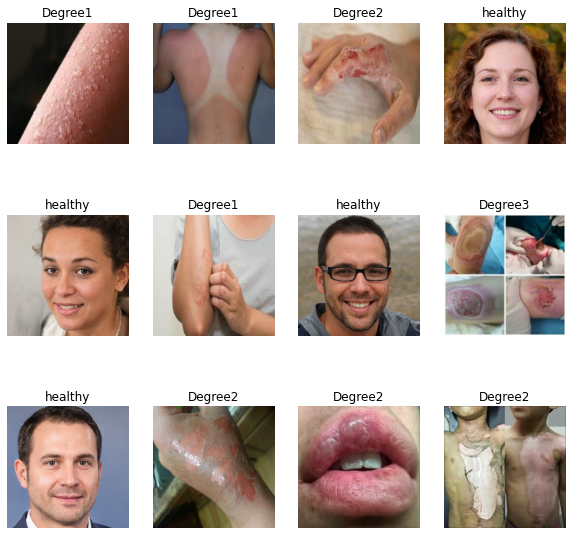

In [30]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(5):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [31]:
len(dataset)

53

In [32]:
train_size = 0.8
len(dataset)*train_size

42.400000000000006

In [33]:
train_ds = dataset.take(42)
len(train_ds)

42

In [34]:
test_ds = dataset.skip(42)

len(test_ds)

11

In [35]:
val_size=0.1
len(dataset)*val_size

5.300000000000001

In [36]:
val_ds = test_ds.take(5)
len(val_ds)

5

In [37]:
test_ds = test_ds.skip(5)
len(test_ds)

6

In [38]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [39]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
len(train_ds)

42

In [41]:
len(val_ds)

5

In [42]:
len(test_ds)

6

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [45]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [46]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 223, 223, 32)        416       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 111, 111, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 110, 110, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 55, 55, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 54, 54, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    #callbacks =[earlystopping]
)


Epoch 1/100
42/42 [==============================] - 29s 609ms/step - loss: 1.3401 - accuracy: 0.3057 - val_loss: 1.3499 - val_accuracy: 0.3688
Epoch 2/100
42/42 [==============================] - 22s 529ms/step - loss: 1.3340 - accuracy: 0.3236 - val_loss: 1.3892 - val_accuracy: 0.2375
Epoch 3/100
42/42 [==============================] - 23s 534ms/step - loss: 1.2820 - accuracy: 0.3386 - val_loss: 1.1545 - val_accuracy: 0.6000
Epoch 4/100
42/42 [==============================] - 24s 575ms/step - loss: 1.1112 - accuracy: 0.4873 - val_loss: 1.0835 - val_accuracy: 0.5312
Epoch 5/100
42/42 [==============================] - 23s 547ms/step - loss: 0.9311 - accuracy: 0.5777 - val_loss: 0.7935 - val_accuracy: 0.6625
Epoch 6/100
42/42 [==============================] - 24s 564ms/step - loss: 0.8116 - accuracy: 0.6353 - val_loss: 0.7138 - val_accuracy: 0.6500
Epoch 7/100
42/42 [==============================] - 24s 562ms/step - loss: 0.7458 - accuracy: 0.6435 - val_loss: 0.8516 - val_accuracy:

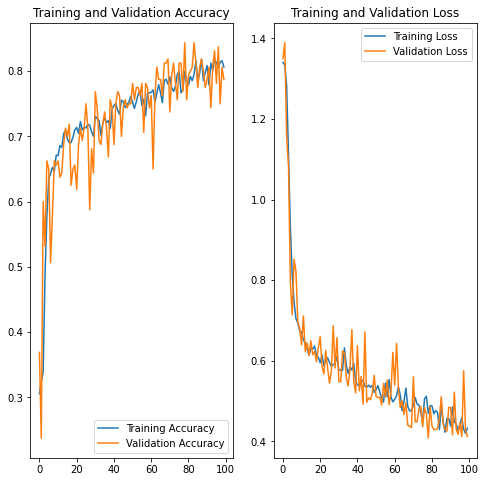

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = 100

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


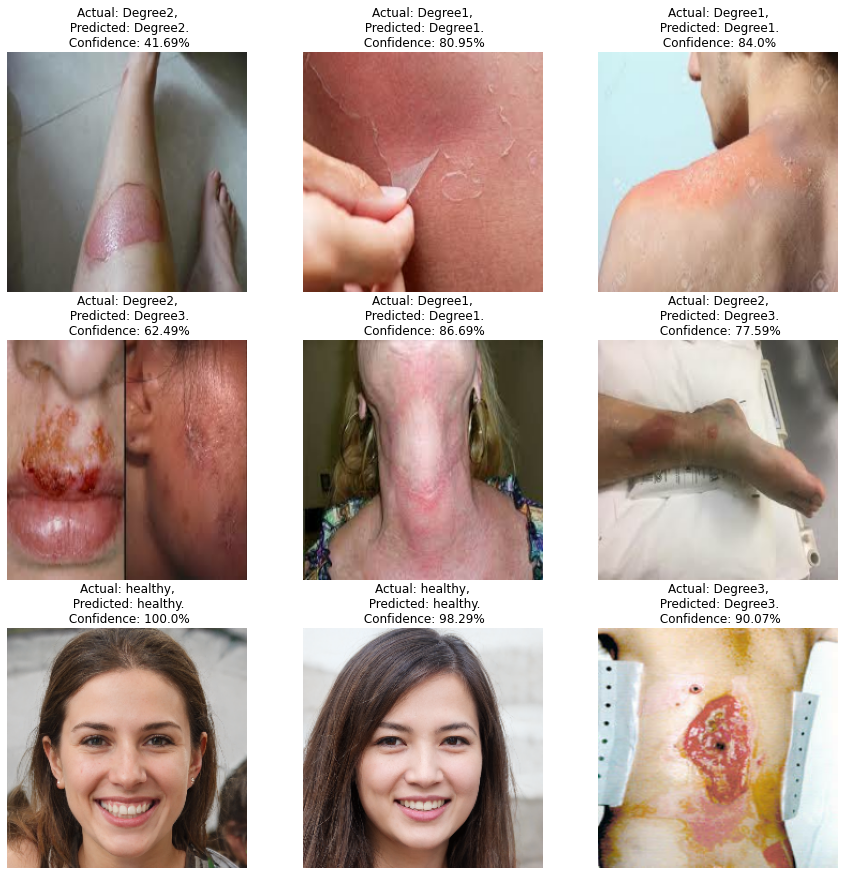

In [81]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")